# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in this article — a great piece of data journalism that's totally worth reading.

<img src=s1gp_actual_vs_displayed.png>


Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

I am going to find out if this "bug" was fixed or not.

In [1]:
import pandas as pd

score = pd.read_csv('fandango_score_comparison.csv')

ratings = pd.read_csv('movie_ratings_16_17.csv')

In [2]:
fandango_previous = score[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                           'Fandango_Difference']].copy()

fandango_after = ratings[['movie', 'year', 'fandango']].copy()

# Changing the Goal of our Analysis


At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

Now we check if both samples contain popular movies - that is, movies with over 30 fan ratings on Fandango's website. 

In [3]:
sum(fandango_previous['Fandango_votes'] < 30) 

0

We generate the years to be able to compare movies made in 2015 vs 2016.

In [4]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]

fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()


2015    129
Name: Year, dtype: int64

In [5]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()

fandango_2016['year'].value_counts()


2016    191
Name: year, dtype: int64

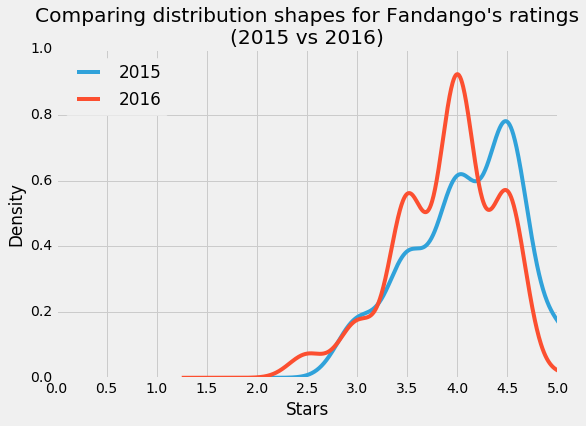

In [6]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label='2015', x = arange(0,5,.5),legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)


plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)")
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.show()

Two aspects are striking on the figure above:

Both distributions are strongly left skewed.
The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

# Comparing Relative Frequencies

In [7]:
import seaborn as sns

print('2015' + '\n' + '-'*20)

fandango_2015['Fandango_Stars'].value_counts(normalize = True).iloc[[3,2,1,0,4]]

2015
--------------------


3.0    0.085271
3.5    0.178295
4.0    0.286822
4.5    0.379845
5.0    0.069767
Name: Fandango_Stars, dtype: float64

In [8]:
print('2016' + '\n' + '-'*20)

fandango_2016['fandango'].value_counts(normalize = True).iloc[[4,3,2,0,1,5]]

2016
--------------------


2.5    0.031414
3.0    0.073298
3.5    0.240838
4.0    0.403141
4.5    0.246073
5.0    0.005236
Name: fandango, dtype: float64

n 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

# Determining the Direction of the Change

In [9]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


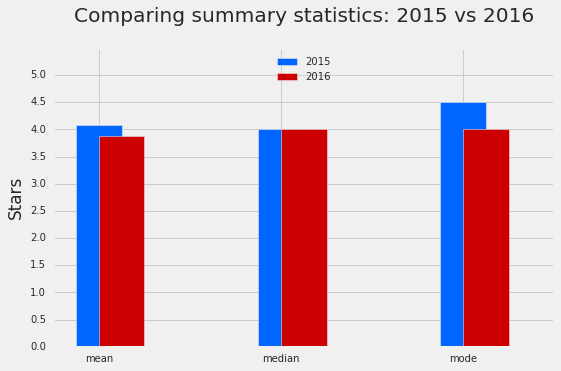

In [10]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

